<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Transfer_Learning_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 718, done.
remote: Counting objects: 100% (718/718), done.
remote: Compressing objects: 100% (611/611), done.
remote: Total 718 (delta 386), reused 229 (delta 97), pack-reused 0
Receiving objects: 100% (718/718), 7.04 MiB | 8.00 MiB/s, done.
Resolving deltas: 100% (386/386), done.
/content/MADSmilestone2
Analysis.ipynb		Labeling	      README.md
CNN2_scores.ipynb	Loading		      Supervised_CNN.ipynb
Data			Model_Datasets.ipynb  Transfer_Learning_Kmeans.ipynb
dataloader_tests.ipynb	multimodel1.ipynb
ImagePlayground		multimodel2.ipynb


In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=bdf587275fa646fd93150798a4cb97381fdc2c49c16408f61a54ba9eeb244cff
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [3]:
!pip install boto3 torchmetrics
from tqdm import tqdm
import boto3
import io
import logging
import os
import ast
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import Loading.load_data as ld


# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchmetrics
from torch.autograd import Variable
import botocore

import tempfile


     |████████████████████████████████| 131 kB 3.9 MB/s 
     |████████████████████████████████| 282 kB 34.7 MB/s 
     |████████████████████████████████| 7.9 MB 49.9 MB/s 
     |████████████████████████████████| 79 kB 5.4 MB/s 
     |████████████████████████████████| 138 kB 49.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# also import keys for aws connection
from gdrive.MyDrive.Colab_Notebooks.clocks_aws_config import clockss3
pubkey = clockss3['accessCode']
seckey = clockss3['secretCode']
client = boto3.client('s3', aws_access_key_id=pubkey, aws_secret_access_key=seckey)
#response = client.list_buckets()

In [144]:
path = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/train_ai.txt'
cust_file = open(path, "r")
#print(cust_file.readline())
contents = cust_file.read() 
dictionarytr = ast.literal_eval(contents)
cust_file.close()

path1 = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/val_dict_nhat.txt'
cust_file = open(path1, "r")
#print(cust_file.readline())
contents = cust_file.read()
dictionaryv = ast.literal_eval(contents)
cust_file.close()

path2 = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/test_dict_nhat.txt'
cust_file = open(path2, "r")
#print(cust_file.readline())
contents = cust_file.read()
dictionaryts = ast.literal_eval(contents)
cust_file.close()

In [145]:
# Define some of the loader variables
train_batch_size = 1
val_batch = 4
test_batch = 1
#rgb_val = None
rnd = 7

normalize_ = True
numpy_ = False

In [ ]:
!pip install graphviz
!pip install hiddenlayer
import torch
import torchvision.models
import hiddenlayer as hl


# Build HiddenLayer graph
# Jupyter Notebook renders it automatically
hl.build_graph(model.to(device), torch.zeros([512, 662]).to(device))

In [146]:
class ResizedClocks():
    #Resized clock drawing dataset

    def __init__(self, round, round_labels, rgb = None, transform = None):
        
       # Args:
           # round (int): Round to grab images from. 
           # values (list of tuples): Corresponding values for the round.
        
        self.round = round
        self.vals = round_labels
        self.client = boto3.client('s3', 
                                    aws_access_key_id=pubkey, 
                                    aws_secret_access_key=seckey)
        self.transform = transform
        self.rgb = rgb
    
    def __len__(self):
        return len(self.vals)

    #def get_labels(self, idx):
        #return self.vals[idx][1]#self.vals[:, 1]

    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = torch.tensor(int(self.vals[idx][1]))
        bucket = "clockimages" #"test-bucket-clockids-aicrowd"
        obj_name = f"NHATS_R{self.round}_ClockDrawings/{spid}.tif" #f"{self.round}_{spid}.tif"
        #filename = str(spid)+".tif"
        temp = tempfile.NamedTemporaryFile()

        try:
          client.download_file(bucket, obj_name, temp.name)# filename)

          im = Image.open(temp.name)#filename)

          if self.rgb:
            #print('rgb')
            gray = im.convert('RGB')
            
          else:
            #print('gray')
            gray = im.convert('1')

            
          resized = gray.resize((284, 368))#160, 207))#(2560, 3312)) 
          #resized = gray.resize((512, 662)) 
          im_arr = np.array(resized)#.astype(float)
          

          if self.transform:
            im_arr = self.transform(im_arr)

          #sample = {'image': im_arr, 'label': label}
        
          temp.close()

          return im_arr, label
          
        except botocore.exceptions.ClientError as e:
          return 






def collate_fn(batch):
  """From pytorch - way to bypass corrupt or non-existent data"""
  batch = list(filter(lambda x: x is not None, batch))
  return torch.utils.data.dataloader.default_collate(batch)





# initialize transformation: data to tensor and normalize
# Could probably resize using torch.transforms


if normalize_ == True:
  processes = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  rgb_val = 'True'
else:
  processes = transforms.ToTensor()
  rgb_val = None



# Define which round to get data from
if numpy_ == False:
  # Get the data from S3 and perform transformations
  train_set = ResizedClocks(rnd, dictionarytr[rnd], transform = processes, rgb = rgb_val)
  val_set = ResizedClocks(rnd, dictionaryv[rnd], transform = processes, rgb = rgb_val)
  test_set = ResizedClocks(rnd, dictionaryts[rnd], transform = processes, rgb = rgb_val)


# Define Dataloaders for the network
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle = True, num_workers = 6, collate_fn=collate_fn) 
validate_loader = torch.utils.data.DataLoader(val_set, batch_size = val_batch, shuffle = True, num_workers = 6, collate_fn=collate_fn) #64, 8,1


# For round 10, there are some corrupt data that when batched at size 1 is not taken
# care of by the collate function, but Nonechucks library skips the missing data and 
# moves on, replacing that missing data index with the next piece of data
# could probably just use this in place of collate for all the loading
if rnd == 10:
  !pip install nonechucks
  import nonechucks as nc
  test_set_safe = nc.SafeDataset(test_set)
  test_loader = torch.utils.data.DataLoader(test_set_safe, batch_size = test_batch, shuffle = False)

else:
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_batch, shuffle = False, collate_fn=collate_fn)

In [ ]:
#original size: 2560, 3312
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16). ### TRY kernel 7x7 padding 3
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640                        
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 32) 
    self.bn1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                    
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 64) 
    self.bn2 = nn.BatchNorm2d(64)  

    #self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          #kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
    self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.pool3 = nn.MaxPool2d(2, 2) #Output shape = (None, 46, 35, 128) 
    self.bn3 = nn.BatchNorm2d(128)
    self.do2 = nn.Dropout(0.3)
                                   
                             
    # Fully connected layer
    self.fc1 = nn.Linear(128*64*82,60) #most recent original size of: 512, 662 -->64 x 82
    self.do3 = nn.Dropout(0.4) #40 % probability  
    #self.fc3 = nn.Linear(60, 30)
    self.fc2 = nn.Linear(60, 3) # left with 3 for the three classes                     



  def forward(self, x):
    x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
    #x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = self.bn3(self.pool3(F.relu(self.conv6((x)))))
    x = self.do2(x)
    x = x.view(x.size(0),128*64*82)
    x = F.relu(self.fc1(x))
    x = self.do3(x)
    x = self.fc2(x)
    return x              

# Resnet50 + KMeans

In [147]:
import torch
import torchvision.models as models
import torch.nn as nn
# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mod = 'res50'

if mod == 'res':
  model_ext = '4_hat'
  mPATH = '/content/gdrive/MyDrive/Colab Notebooks/Models/cnn_512_662.model{}'.format(model_ext)
  model = models.resnet50()#'pretrained')
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 3)
  model.load_state_dict(torch.load(mPATH))
  model.to(device)
  print("Res half data")

if mod == 'conv':
  model_ext = '4_fix'
  mPATH = '/content/gdrive/MyDrive/Colab Notebooks/Models/cnn_512_662.model{}'.format(model_ext)
  model = ConvNet()
  #model.load_state_dict(torch.load(mPATH, map_location=torch.device('cpu')))
  model.load_state_dict(torch.load(mPATH))
  model.to(device)
  print("conv")

if mod == 'res50':
  model = models.resnet50(pretrained = True)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 3)
  model = model.to(device)
  print("res 50 pretrained")

res 50 pretrained


In [31]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [148]:
import torch.nn as nn
# Remove prediction layer (last fc layer)
model_1 = nn.Sequential(*list(model.children())[:-1])

In [149]:
# Use model for evaluation
model_1.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
X = []

for x, lb in tqdm(test_loader):
  x = x.to(device)
  preds = model_1(x)
  X.append(preds.cpu())

In [53]:
X[0].shape

torch.Size([1, 2048, 1, 1])

In [54]:
x_ = np.array([t.cpu().detach().numpy() for t in X])
#x_ = np.array([t for t in X])
print("shape: ", x_.shape)

shape:  (254, 1, 2048, 1, 1)


In [55]:
w = x_.reshape(x_.shape[0], -1)
w.shape

(254, 2048)

In [56]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.98 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance)

pca.fit(w) #fit the data according to our PCA instance
print("Number of components before PCA  = " + str(w.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) 
#dimension reduced from 784


Number of components before PCA  = 2048
Number of components after PCA 0.98 = 114


In [57]:
w_pca = pca.transform(w)
print("Dim after PCA: ", w_pca.shape)

Dim after PCA:  (254, 114)


In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil_score = []
kl = []
k_max = 9

for k in range(2, k_max+1):
  kmeans2 = KMeans(n_clusters = k).fit(w)#w)
  labels = kmeans2.labels_
  sil_score.append(silhouette_score(w, labels, metric = 'euclidean'))
  kl.append(k)

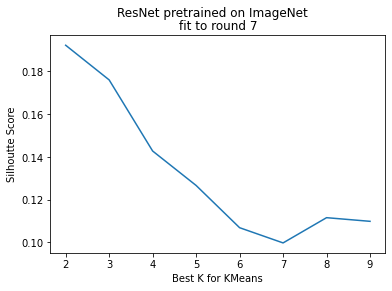

In [62]:
sil_name = '50res_fit7_hatsil.png'
plt.plot(kl, sil_score)
plt.ylabel('Silhoutte Score')
plt.xlabel('Best K for KMeans')
#plt.title('PCA dim from 2048 to 114')
plt.title('fit to round 7')
plt.suptitle('ResNet pretrained on ImageNet')
#plt.title('Res trained on 50% dataset and fit to Round 7')
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/{}'.format(sil_name))
plt.show()

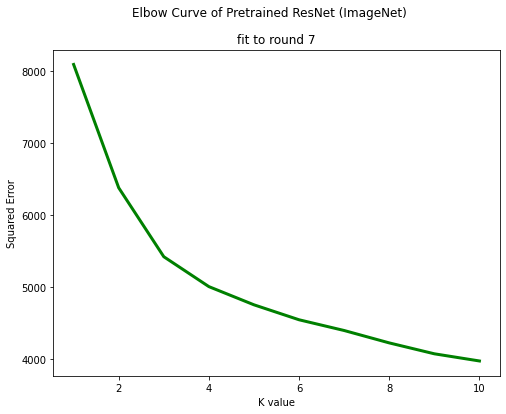

In [63]:
elb_name = '50res_7_hatelb.png'
cost =[]
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(w)
      
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.figure(figsize = (8,6))
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
#plt.title('PCA dim from 2048 to 114')
plt.title('fit to round 7')
plt.suptitle('Elbow Curve of Pretrained ResNet (ImageNet)')
#plt.title('Res trained on 50% dataset and fit to Round 7')
plt.xlabel("K value")
plt.ylabel("Squared Error")

plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/{}'.format(elb_name))

plt.show() # clear the plot
# the point of the elbow is the 
# most optimal value for choosing k

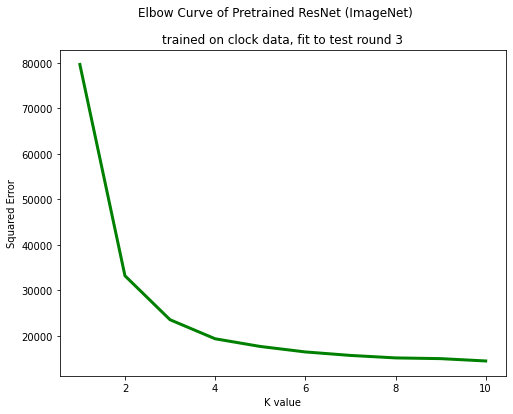

In [22]:
# plot the cost against K values
plt.figure(figsize = (8,6))
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.title('trained on clock data, fit to test round 3')
plt.suptitle('Elbow Curve of Pretrained ResNet (ImageNet)')
#plt.title('Res trained on 50% dataset and fit to Round 7')
plt.xlabel("K value")
plt.ylabel("Squared Error")

plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/{}'.format(elb_name))

plt.show() # clear the plot
# the point of the elbow is the 
# most optimal value for choosing k

In [ ]:
"""model_ft = models.resnet18(pretrained=True)
### strip the last layer
feature_extractor = torch.nn.Sequential(*list(model_ft.children())[:-1])
### check this works
output_arr = torch.zeros(1,512)
ims = []
out_arr = []"""


In [ ]:
#print("new shape: ", x_test.reshape(-1, 207, 160, 3).shape) # 254 samples images of size 207 x 160 x 3
#x_test[:1]

# Apply optimal K with clustering for labeling

In [159]:
x_trainK = []
y_train = []
# Pulling in data from round 3 to predict labels
# Since we predicted optimal clusters with resnet50 trained on rounds 1, 5, 6, 7
for x, lb in tqdm(train_loader):
  x_trainK.append(x)
  y_train.append(lb)
  #preds = model(x)
  #make_dot(preds.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

100%|██████████| 2445/2445 [04:18<00:00,  9.47it/s]


In [160]:
#y_train_ = np.array([t.numpy() for t in y_train])
y_train_ = np.array(y_train)
print("shape: ", (y_train_).shape)
print(type(y_train_))
y_train_

shape:  (2445,)
<class 'numpy.ndarray'>


array([2, 2, 2, ..., 2, 2, 1])

In [161]:
x_train_ = np.array([t.numpy() for t in x_trainK])
print("shape: ", x_train_.shape)
print(type(x_train_))
x_train_[:1]

shape:  (2445, 1, 3, 368, 284)
<class 'numpy.ndarray'>


array([[[[[2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
           2.2489083],
          [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
           2.2489083],
          [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
           2.2489083],
          ...,
          [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
           1.2556726],
          [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
           1.1529241],
          [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2317834,
           1.0844251]],

         [[2.4285715, 2.4285715, 2.4285715, ..., 2.4285715, 2.4285715,
           2.4285715],
          [2.4285715, 2.4285715, 2.4285715, ..., 2.4285715, 2.4285715,
           2.4285715],
          [2.4285715, 2.4285715, 2.4285715, ..., 2.4285715, 2.4285715,
           2.4285715],
          ...,
          [2.4285715, 2.4285715, 2.4285715, ..., 2.4285715, 2.4285715,
           1.4131653],
          [2.4285715, 2.4285

In [162]:
X_train = x_train_.reshape(x_train_.shape[0], -1) # reshaped to # samples and flattened dims
X_train.shape

(2445, 313536)

In [133]:
from sklearn.decomposition import PCA
variance = 0.98 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance)
pca.fit(X_train)
pct = pca.transform(X_train)

In [163]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(X_train)
kmeans.labels_

array([1, 0, 0, ..., 0, 1, 2], dtype=int32)

In [85]:
y_train_

array([2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 0,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2])

In [72]:
kmeans.labels_.shape

(254,)

In [155]:
clusters = kmeans.fit_predict(X_train)
kmeans.cluster_centers_.shape

(3, 313536)

In [126]:
correct_pred = (clusters == y_train_)
  #acc = correct_pred.sum() / len(correct_pred)
print(correct_pred)
print(correct_pred.sum())
len(correct_pred)
acc = correct_pred.sum()/len(correct_pred)
acc

[False False False ... False  True False]
814


0.3330605564648118

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


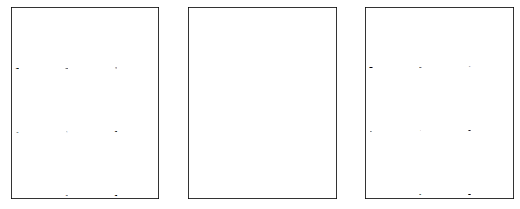

In [167]:
fig, ax = plt.subplots(1, 3, figsize=(9, 11))
centers = kmeans.cluster_centers_.reshape(3, 368, 284, 3)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [164]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score


labels = np.zeros_like(kmeans.labels_)
for i in range(3):
    mask = (kmeans.labels_ == i)
    #print(mask)
    labels[mask] = mode(y_train_[mask])[0]


accuracy_score(y_train_, labels)


0.3967280163599182

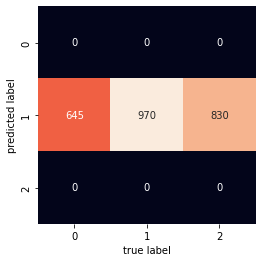

In [165]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_train_, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel('true label')
plt.ylabel('predicted label');

Using NHATS label for round 7 fit on Pretrained ReNet50 on ImageNet only using 3 clusters was 79% accurate compared to cluster labels 


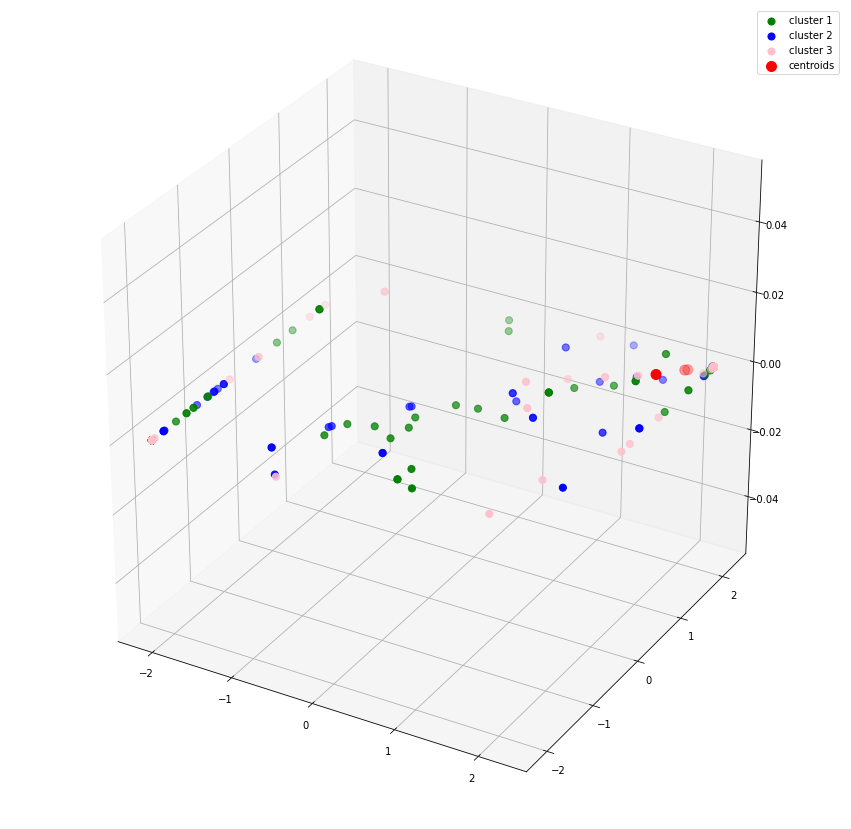

In [128]:
#y_pred = kmeans.predict(X_train)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(X_train[clusters == 0,0],X_train[clusters == 0,1],s = 50, c = 'green', label = "cluster 1")
plt.scatter(X_train[clusters == 1,0],X_train[clusters == 1,1],s = 50, c = 'blue', label = "cluster 2")
plt.scatter(X_train[clusters == 2,0],X_train[clusters == 2,1],s = 50, c = 'pink', label = "cluster 3")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s = 100, c = "red", label = "centroids")
plt.legend()
plt.show()

# With Keras

In [ ]:
keras_x = []

for xk, _ in tqdm(test_loader):
  keras_x.append(xk)

100%|██████████| 254/254 [02:15<00:00,  1.87it/s]


In [ ]:
print("shape of keras_x: ", keras_x[0].shape)
karr = np.array([t.cpu().detach().numpy() for t in keras_x])
print("shape: ", karr.shape)
im1= karr.reshape(len(keras_x), -1, 3)
print('shape: ', im1.shape)
print("dtype: ", im1.dtype)
print("type: ", type(im1))

img1 = Image.fromarray(im1, 'RGB')
im_arr2 = np.float32(np.array(img1))
im_arr2.shape

shape of keras_x:  torch.Size([1, 3, 207, 160])
shape:  (254, 1, 3, 207, 160)
shape:  (254, 33120, 3)
dtype:  float32
type:  <class 'numpy.ndarray'>


(254, 33120, 3)

In [ ]:
import tensorflow as tf 
model_keras = tf.keras.applications.MobileNetV2(include_top=False,
weights= 'imagenet', input_shape=(207, 160, 3))

print("Image shape before model: ", im_arr2.shape)
predictions1 = model_keras.predict(im_arr2.reshape(-1, 207, 160, 3))
print("preds shape after model: ", predictions1.shape)

Image shape before model:  (254, 33120, 3)
preds shape after model:  (254, 7, 5, 1280)


In [ ]:
pred_images1 = predictions1.reshape(im_arr2.shape[0], -1)
print("Shape of prediction images: ", pred_images1.shape)

Shape of prediction images:  (254, 44800)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil_score = []
kl = []
k_max = 9

for k in range(2, k_max+1):
  kmeans2 = KMeans(n_clusters = k).fit(pred_images1)
  labels = kmeans2.labels_
  sil_score.append(silhouette_score(pred_images1, labels, metric = 'euclidean'))
  kl.append(k)

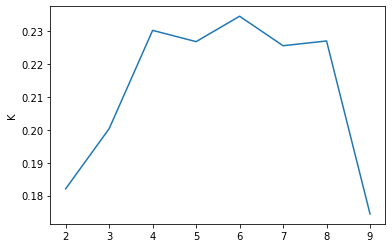

In [ ]:
plt.plot(kl, sil_score)
plt.ylabel('Silhoutte Score')
plt.ylabel('K')
plt.show()

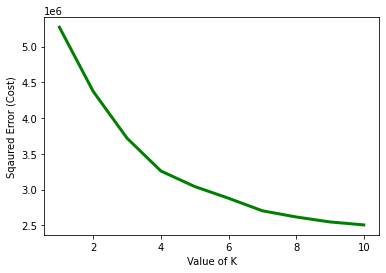

In [ ]:
cost =[]
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(pred_images1)
      
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot
  
# the point of the elbow is the 
# most optimal value for choosing k

# Other ways to extract features from modela

---




In [ ]:
samples = len(ims)  # Amount of samples to take from input path

vec_length = 512  # Using resnet-18 as default
# Matrix to hold the image vectors
vec_mat = np.zeros((samples, vec_length))

for index, i in enumerate(test_loader):
    x = i[0]
    vec = feature_extractor(x).reshape(-1, 512)
    vec_mat[index, :] = vec.detach().numpy()

In [ ]:
vec_mat.shape # Each image feature vectors

(254, 512)

In [ ]:
from sklearn.decomposition import PCA
less_features = PCA(n_components=2).fit_transform(vec_mat)


# Using data stored in numpy files - testing ground for Keras




In [ ]:
"""convert_data = 'False'
if convert_data == "True":
  tr_im_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/balanced_training.npy"
  tr_lb_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/balanced_train_labels.npy"
  val_im_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_im_nobal.npy"
  val_lb_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_labels_im_nobal.npy"
  tst_im_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/test_im_nobal.npy"
  tst_lb_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_labels_im_nobal.npy"

  training_data, y_train_tensor = ld.load_np_files(tr_im_path, tr_lb_path)
  validation_data, y_val_tensor = ld.load_np_files(val_im_path, val_lb_path)
  test_data, y_test_tensor = ld.load_np_files(tst_im_path, tst_lb_path)

  train_data = list(zip(*training_data))
  X_train = np.asarray(train_data[0])
  y_train = np.asarray(train_data[1])

  val_data = list(zip(*validation_data))
  X_val = np.asarray(val_data[0])
  y_val = np.asarray(val_data[1])


  t_data = list(zip(*test_data))
  X_test = np.asarray(t_data[0])
  y_test = np.asarray(t_data[1])

  with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/train', 'wb') as f:
    np.save(f, X_train)
  with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/train_y', 'wb') as f:
    np.save(f, y_train)
  with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val', 'wb') as f:
    np.save(f, X_val)
  with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_y', 'wb') as f:
    np.save(f, y_val)
  with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/test', 'wb') as f:
    np.save(f, X_test)
  with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/test_y', 'wb') as f:
    np.save(f, y_test)
  """
#else:
  # load data
  #with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/train', 'rb') as f:
    #train_set = np.load(f)
  #with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/train_y', 'rb') as f:
    #train_y = np.load(f)
with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val', 'rb') as f:
  val_set = np.load(f)
with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_y', 'rb') as f:#
  val_y = np.load(f)
with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/test', 'rb') as f:
  test_set = np.load(f)
with open('/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/test_y', 'rb') as f:
  test_y = np.load(f)

In [ ]:
"""print(train_set.shape)
print(train_y.shape)"""
print(val_set.shape)
print(val_y.shape)
print(test_set.shape)
print(test_y.shape)2541

(2541, 1, 368, 284)
(2541,)


In [ ]:
images = test_set.reshape(len(test_set), -1)
images.shape

(2541, 104512)

In [ ]:
img = Image.fromarray(images, 'RGB')
im_arr = np.float32(np.array(img))
im_arr.shape

(2541, 104512, 3)

In [ ]:
import tensorflow as tf 
model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(368, 284,3))
print("imr shape: ", im_arr.shape)
predictions = model.predict(im_arr.reshape(-1, 368, 284,3))
#pred_images = predictions.reshape(im_arr.shape[0], -1)
predictions.shape

imr shape:  (2541, 104512, 3)


(2541, 12, 9, 1280)

In [ ]:
pred_images = predictions.reshape(im_arr.shape[0], -1)
pred_images.shape

(2541, 138240)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil = []
kl = []
kmax = 10

for k in range(2, kmax+1):
  kmeans2 = KMeans(n_clusters = k).fit(pred_images)
  labels = kmeans2.labels_
  sil.append(silhouette_score(pred_images, labels, metric = 'euclidean'))
  kl.append(k)

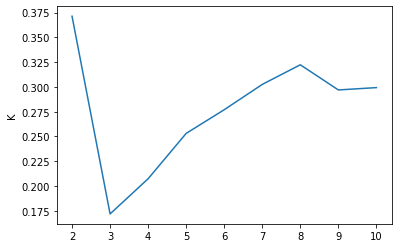

In [ ]:
plt.plot(kl, sil)
plt.ylabel('Silhoutte Score')
plt.ylabel('K')
plt.show()

# Logistic Regression

In [ ]:
 model = models.resnet50(pretrained=True)

 # extact feature layer
 layer = model._modules.get('avgpool')
 layer

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(solver = 'lbfgs')

In [ ]:
val = val_set.reshape(2544,1*368*284)
test = test_set.reshape(2541,1*368*284)

In [ ]:
# fit the model
clf.fit(val, val_y.ravel())

# prediction for training dataset
train_pred = clf.predict(val)

# prediction for testing dataset
test_pred = clf.predict(test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred, val_y))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred, test_y))

Accuracy score for Training Dataset =  0.9386792452830188
Accuracy score for Testing Dataset =  0.602125147579693


In [ ]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(val_y.ravel(), train_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted    0    1     2   All
True                           
0          536    5    48   589
1            9  177    38   224
2           35   21  1675  1731
All        580  203  1761  2544


In [ ]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(test_y.ravel(), test_pred.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted    0    1     2   All
True                           
0           88   27   474   589
1           35    9   180   224
2          228   67  1433  1728
All        351  103  2087  2541


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X_train_new, y_train_new = sm.fit_sample(val, val_y.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


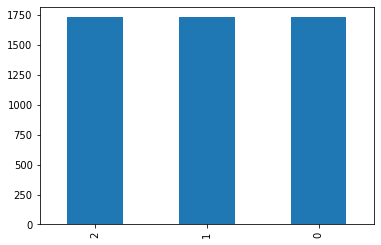

In [ ]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [ ]:
#fit the model
clf.fit(X_train_new, y_train_new)

# prediction for Training data
train_pred_sm = clf.predict(X_train_new)


In [ ]:
# prediction for Testing data
test_pred_sm = clf.predict(test)

In [ ]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred_sm, y_train_new))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_sm, test_y))


print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train_new, train_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))

Accuracy score for Training Dataset =  0.9616791835162719
Accuracy score for Testing Dataset =  0.6092089728453365
Confusion Matrix - Training Dataset
Predicted     0     1     2   All
True                             
0          1634    11    86  1731
1             6  1676    49  1731
2            26    21  1684  1731
All        1666  1708  1819  5193


In [ ]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(test_y.ravel(), test_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))


Confusion Matrix - Testing Dataset
Predicted    0    1     2   All
True                           
0           59   20   510   589
1           28   16   180   224
2          165   90  1473  1728
All        252  126  2163  2541


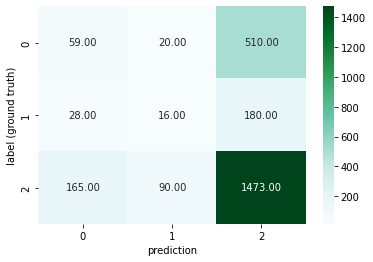

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_y, test_pred_sm))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
#plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/CMTX{}.png'.format(extension_))
plt.show()